# Predicting the property crime rate in states using machine learning 

In this notebook, we will use the FBI's UCR (Uniform Crime Reporting) to create a time-series to perform a regression analysis on to see property crime rates in various states and forecast potential property crimes. 

## 1. Problem Definition 
Predict property crime rates by a state-by-state basis. 

## 2. Data

The data has been downloaded by the FBI's UCR crime explorer.
https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/explorer/crime/crime-trend

## 3. Evaluation
To evaluate our time series predictions, we will use multiple metrics:

1. RMSE (Root Mean Square Error)
   * Primary metric
   * Measures average prediction error in actual crime rate units
   * More weight to large errors
   * Interpretable: "On average, our predictions are off by X crimes per 100,000 population"

2. MAPE (Mean Absolute Percentage Error)
   * Shows error as a percentage
   * Useful for comparing accuracy across states with different crime rates
   * Easy to explain: "Our predictions are off by X% on average"

3. R² Score
   * Indicates how much of the variance in crime rates our model explains
   * Useful for model comparison and communication with stakeholders

## 4. Features

### 1. Clean data 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [39]:
def process_state_file(file_path):
    """
    Process individual state crime rate files with persistent type conversion
    """
    # Extract state name from filename
    state = os.path.basename(file_path).replace('_PropertyCrimeRate.csv', '')
    
    # Read the CSV
    df = pd.read_csv(file_path)
    
    # Get the state's crime rate series (first row)
    state_data = df.iloc[0]
    
    # Convert to long format with explicit type conversion
    data_long = pd.DataFrame({
        'date': pd.to_datetime(state_data.index[1:], format='%m-%Y'),
        'crime_rate': pd.to_numeric(state_data.values[1:], errors='coerce'),
        'state': state
    })
    
    # Force types immediately
    data_long = data_long.astype({
        'crime_rate': 'float64',
        'state': 'string'
    })
    
    print(f"Processed {state}")
    return data_long

In [40]:
def combine_state_files(data_directory):
    """
    Combine all state files with guaranteed type consistency
    """
    files = glob.glob(os.path.join(data_directory, '*_PropertyCrimeRate.csv'))
    
    all_states = []
    for file in files:
        state_df = process_state_file(file)
        # Verify types before appending
        assert state_df['crime_rate'].dtype == 'float64', f"Crime rate not float64 in {file}"
        assert state_df['state'].dtype == 'string', f"State not string in {file}"
        all_states.append(state_df)
    
    # Combine all states
    combined_df = pd.concat(all_states, ignore_index=True)
    
    # Force types again after concatenation
    combined_df = combined_df.astype({
        'crime_rate': 'float64',
        'state': 'string'
    })
    
    # Sort by state and date
    combined_df = combined_df.sort_values(['state', 'date'])
    
    return combined_df


In [17]:
def validate_combined_data(df):
    """
    Validate the combined dataset
    
    Parameters:
    df (pd.DataFrame): Combined state data
    
    Returns:
    dict: Validation statistics
    """
    stats = {
        'total_states': df['state'].nunique(),
        'date_range': (df['date'].min(), df['date'].max()),
        'missing_values': df.isnull().sum().to_dict(),
        'states_missing_data': []
    }
    
    # Check for states with incomplete time series
    expected_counts = len(df['date'].unique())
    state_counts = df.groupby('state').size()
    missing_data_states = state_counts[state_counts < expected_counts]
    stats['states_missing_data'] = missing_data_states.index.tolist()
    
    return stats

In [44]:
# Example usage in Jupyter:
data_dir = r'data/StateCrimes'
m_combined_data = combine_state_files(data_dir)

# Look at the raw data
print("\nFirst few rows:")
print(m_combined_data.head())

# Basic info about the dataset
print("\nDataset Info:")
print(m_combined_data.info())

# Save raw data
m_combined_data.to_csv("raw_combined_state_crime_rates.csv", index=False)

# Verify types after saving and reloading
reloaded_data = pd.read_csv("raw_combined_state_crime_rates.csv",
                           dtype={'state': 'string'},
                           parse_dates=['date'])
reloaded_data['crime_rate'] = pd.to_numeric(reloaded_data['crime_rate'], errors='coerce')

print("\nReloaded Dataset Info:")
print(reloaded_data.info())

Processed Alabama
Processed Alaska
Processed Arizona
Processed Arkansas
Processed California
Processed Colorado
Processed Connecticut
Processed Delaware
Processed DistrictOfColumbia
Processed Florida
Processed Georgia
Processed Hawaii
Processed Idaho
Processed Illinois
Processed Indiana
Processed Iowa
Processed Kansas
Processed Kentucky
Processed Louisiana
Processed Maine
Processed Maryland
Processed Massachusetts
Processed Michigan
Processed Minnesota
Processed Mississippi
Processed Missouri
Processed Montana
Processed Nebraska
Processed Nevada
Processed NewHampshire
Processed NewMexico
Processed NewYersey
Processed NewYork
Processed NorthCarolina
Processed NorthDakota
Processed Ohio
Processed Oklahoma
Processed Oregon
Processed Pennsylvania
Processed RhodeIsland
Processed SouthCarolina
Processed SouthDakkota
Processed Tennessee
Processed Texas
Processed US
Processed Utah
Processed Vermont
Processed Virginia
Processed Washington
Processed WestVirginia
Processed Wisconsin
Processed Wyo

In [45]:
# Convert state to categorical
m_combined_data['state'] = m_combined_data['state'].astype('category')

# Verify the change
print("\nUpdated Dataset Info:")
print(m_combined_data.info())


Updated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24856 entries, 0 to 24855
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        24856 non-null  datetime64[ns]
 1   crime_rate  24304 non-null  float64       
 2   state       24856 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 415.2 KB
None


In [46]:
# Verify 
# See unique categories
print("\nState Categories:")
print(m_combined_data['state'].cat.categories)

# Get memory usage comparison
print("\nMemory usage for state column:")
print(f"Before (as string): {m_combined_data['state'].astype('string').memory_usage(deep=True) / 1024:.2f} KB")
print(f"After (as category): {m_combined_data['state'].memory_usage(deep=True) / 1024:.2f} KB")


State Categories:
Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'DistrictOfColumbia', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'NewHampshire', 'NewMexico', 'NewYersey', 'NewYork', 'NorthCarolina',
       'NorthDakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'RhodeIsland', 'SouthCarolina', 'SouthDakkota', 'Tennessee', 'Texas',
       'US', 'Utah', 'Vermont', 'Virginia', 'Washington', 'WestVirginia',
       'Wisconsin', 'Wyoming'],
      dtype='string')

Memory usage for state column:
Before (as string): 1391.65 KB
After (as category): 29.37 KB


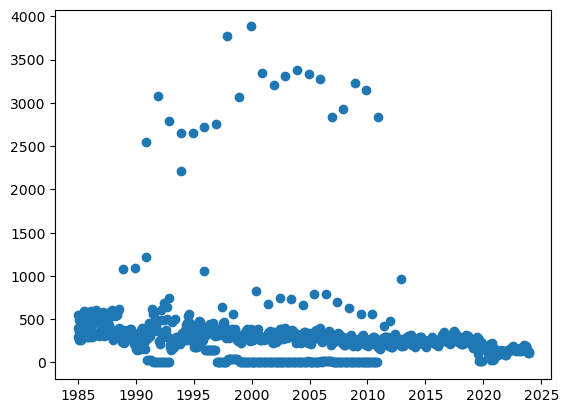

In [34]:
fig, ax = plt.subplots()
ax.scatter(m_combined_data['date'][:1000], m_combined_data['crime_rate'][:1000]);

In [35]:
validate_combined_data(m_combined_data)

{'total_states': 52,
 'date_range': (Timestamp('1985-01-01 00:00:00'),
  Timestamp('2024-10-01 00:00:00')),
 'missing_values': {'date': 0, 'crime_rate': 552, 'state': 0},
 'states_missing_data': []}

In [29]:
# Make a copy 
m_combined_data_copy = m_combined_data

In [50]:
m_combined_data.state.value_counts()

state
Alabama               478
Alaska                478
Nevada                478
NewHampshire          478
NewMexico             478
NewYersey             478
NewYork               478
NorthCarolina         478
NorthDakota           478
Ohio                  478
Oklahoma              478
Oregon                478
Pennsylvania          478
RhodeIsland           478
SouthCarolina         478
SouthDakkota          478
Tennessee             478
Texas                 478
US                    478
Utah                  478
Vermont               478
Virginia              478
Washington            478
WestVirginia          478
Wisconsin             478
Nebraska              478
Montana               478
Missouri              478
Idaho                 478
Arizona               478
Arkansas              478
California            478
Colorado              478
Connecticut           478
Delaware              478
DistrictOfColumbia    478
Florida               478
Georgia               478
Hawaii

In [56]:
# Check missing data
m_combined_data.isnull().sum()/len(m_combined_data)

date          0.000000
crime_rate    0.022208
state         0.000000
dtype: float64

## Save preprocessed data 

In [57]:
# Export current tmp dataframe 
m_combined_data.to_csv('raw_combined_state_crime_rates_preprocessed.csv')

In [58]:
# Import preprocessed data
m_combined_data = pd.read_csv('raw_combined_state_crime_rates_preprocessed.csv')
m_combined_data.head()

,Unnamed: 0,date,crime_rate,state
0,0,1985-01-01,296.58,Alabama
1,1,1985-02-01,261.86,Alabama
2,2,1985-03-01,288.37,Alabama
3,3,1985-04-01,265.32,Alabama
4,4,1985-05-01,281.24,Alabama


In [59]:
# Check missing values by state
missing_by_state = (m_combined_data.groupby('state')
                   .agg({'crime_rate': lambda x: x.isnull().sum()})
                   .rename(columns={'crime_rate': 'missing_values'})
                   .sort_values('missing_values', ascending=False))

print("Number of missing values by state:")
print(missing_by_state[missing_by_state['missing_values'] > 0])

Number of missing values by state:
                    missing_values
state                             
Montana                         33
Kentucky                        19
Nebraska                        10
NewHampshire                    10
NewMexico                       10
NewYersey                       10
NewYork                         10
NorthCarolina                   10
NorthDakota                     10
Ohio                            10
Oklahoma                        10
Oregon                          10
Pennsylvania                    10
RhodeIsland                     10
SouthCarolina                   10
SouthDakkota                    10
Tennessee                       10
Texas                           10
US                              10
Utah                            10
Vermont                         10
Virginia                        10
Washington                      10
WestVirginia                    10
Wisconsin                       10
Nevada              

In [60]:
# Fill missing values with state-specific medians
state_medians = m_combined_data.groupby('state')['crime_rate'].transform('median')
m_combined_data['crime_rate_filled'] = m_combined_data['crime_rate'].fillna(state_medians)

# Verify the fill worked
print("\nMissing values after filling:")
print(m_combined_data['crime_rate_filled'].isnull().sum())


Missing values after filling:
0


In [63]:
# Check missing values by state
missing_by_state = (m_combined_data.groupby('state')
                   .agg({'crime_rate': lambda x: x.isnull().sum()})
                   .rename(columns={'crime_rate': 'missing_values'})
                   .sort_values('missing_values', ascending=False))

print("\nNumber of missing values by state:")
print(missing_by_state[missing_by_state['missing_values'] > 0])

# For states with missing values, let's look at their patterns
states_with_missing = missing_by_state[missing_by_state['missing_values'] > 0].index

for state in states_with_missing:
    state_data = m_combined_data[m_combined_data['state'] == state]
    print(f"\n{state} Statistics:")
    print("Time range:", state_data['date'].min(), "to", state_data['date'].max())
    print("Missing months:", state_data['crime_rate'].isnull().sum())
    print("State median:", state_data['crime_rate'].median())
    print("Missing pattern:")
    print(state_data[state_data['crime_rate'].isnull()][['date', 'crime_rate']].head())


Number of missing values by state:
                    missing_values
state                             
Montana                         33
Kentucky                        19
Nebraska                        10
NewHampshire                    10
NewMexico                       10
NewYersey                       10
NewYork                         10
NorthCarolina                   10
NorthDakota                     10
Ohio                            10
Oklahoma                        10
Oregon                          10
Pennsylvania                    10
RhodeIsland                     10
SouthCarolina                   10
SouthDakkota                    10
Tennessee                       10
Texas                           10
US                              10
Utah                            10
Vermont                         10
Virginia                        10
Washington                      10
WestVirginia                    10
Wisconsin                       10
Nevada             

In [67]:
# Let's look at where these gaps are occurring
def analyze_missing_pattern(df, state_name):
    state_data = df[df['state'] == state_name]
    
    # Ensure dates are datetime objects
    missing_dates = pd.to_datetime(state_data[state_data['crime_rate'].isnull()]['date'])
    missing_dates_sorted = sorted(missing_dates)
    
    # Print raw data for debugging
    print(f"\nFirst few missing dates for {state_name}:")
    for date in missing_dates_sorted[:5]:
        print(f"Date type: {type(date)}, Value: {date}")
    
    return {
        'missing_dates': missing_dates_sorted,
        'total_missing': len(missing_dates),
        'first_missing': missing_dates_sorted[0] if missing_dates_sorted else None,
        'last_missing': missing_dates_sorted[-1] if missing_dates_sorted else None
    }

# Analyze patterns for a few states
states_to_check = ['Montana', 'Kentucky', 'Alabama']  # one from each pattern
for state in states_to_check:
    print(f"\n{state} Missing Data Analysis:")
    pattern = analyze_missing_pattern(m_combined_data, state)
    print(f"Total missing: {pattern['total_missing']}")
    print(f"First missing: {pattern['first_missing']}")
    print(f"Last missing: {pattern['last_missing']}")
    print("\nAll missing dates:")
    for date in pattern['missing_dates']:
        print(date)

# Let's also look at the overall data structure
print("\nDataFrame Info:")
print(m_combined_data.info())
print("\nDate column type:", m_combined_data['date'].dtype)


Montana Missing Data Analysis:

First few missing dates for Montana:
Date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, Value: 1994-01-01 00:00:00
Date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, Value: 1994-02-01 00:00:00
Date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, Value: 1994-03-01 00:00:00
Date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, Value: 1994-04-01 00:00:00
Date type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>, Value: 1994-05-01 00:00:00
Total missing: 33
First missing: 1994-01-01 00:00:00
Last missing: 2024-10-01 00:00:00

All missing dates:
1994-01-01 00:00:00
1994-02-01 00:00:00
1994-03-01 00:00:00
1994-04-01 00:00:00
1994-05-01 00:00:00
1994-06-01 00:00:00
1994-07-01 00:00:00
1994-08-01 00:00:00
1994-09-01 00:00:00
1994-10-01 00:00:00
1994-11-01 00:00:00
1994-12-01 00:00:00
1996-01-01 00:00:00
1996-02-01 00:00:00
1996-03-01 00:00:00
1996-04-01 00:00:00
1996-05-01 00:00:00
1996-07-01 00:00:00
1996-08-01 00